<a href="https://colab.research.google.com/github/DeMiKe16/k_brazos_VLB/blob/main/bandit_experiment_epsilongreedy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.

- Se generan gráficas de recompensas promedio para cada algoritmo.
- Se generan gráficas de selecciones óptimas para cada algoritmo.
- Se generan gráficas de estadísticas de brazos para cada algoritmo.
- Se generan gráficas de arrepentimiento promedio para cada algoritmo.


# Autores:
- Alejandro López Cuéllar
- Miguel Ángel Vera Frutos
- Alejandro Belda Fernández

## Librerias

In [ ]:
! git clone https://github.com/DeMiKe16/k_brazos_VLB.git

Cloning into 'k_brazos_VLB'...
remote: Enumerating objects: 171, done.
remote: Counting objects: 100% (171/171), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 171 (delta 75), reused 122 (delta 39), pack-reused 0 (from 0)
Receiving objects: 100% (171/171), 11.68 MiB | 33.69 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [ ]:
! pip install numpy matplotlib


In [ ]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/k_brazos_VLB')
sys.path.append('/content/k_brazos_VLB/src')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from src.algorithms import Algorithm, EpsilonGreedy
from src.arms import ArmNormal, ArmBernoulli, ArmBinomial, Bandit
from src.plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['/content', '/env/python', '/usr/lib/python311.zip', '/usr/lib/python3.11', '/usr/lib/python3.11/lib-dynload', '', '/usr/local/lib/python3.11/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.11/dist-packages/IPython/extensions', '/root/.ipython', '/content/k_brazos_VLB', '/content/k_brazos_VLB/src']


## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

Este código realiza el experimento del bandido multi-brazo. Para ello se ejecutan ejecuciones (`runs`) y pasos (`steps`), registrando recompensas promedio, porcentaje de selecciones óptimas y el arrepentimiento que es la diferencia entre la recompensa esperada del brazo óptimo y la del brazo seleccionado. Cada algoritmo elige un brazo, obtiene su recompensa y actualiza su estimación, mientras que se almacenan estadísticas sobre el número de veces que se ha seleccionado cada brazo y su recompensa promedio. Finalmente, los resultados se promedian sobre las ejecuciones y se retornan como matrices de recompensas, selecciones óptimas, estadísticas de los brazos y el arrepentimiento.

In [ ]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret.


    arm_stats = [
        [{"arm": i + 1, "promedy_rewards": 0.0, "times_pulled": 0, "optimal": i==optimal_arm} for i in range(bandit.k)]
        for _ in range(len(algorithms))
        ]


    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.



    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                regret[idx, step] += current_bandit.get_expected_value(optimal_arm) - current_bandit.get_expected_value(chosen_arm)


                optimal_selections[idx, step] += (chosen_arm == optimal_arm)
                arm_stats[idx][chosen_arm]["times_pulled"] += 1
                arm_stats[idx][chosen_arm]["promedy_rewards"] += reward



    rewards /= runs
    regret /= runs
    for algo_idx in range(len(algorithms)):
        for arm_idx in range(bandit.k):
            if arm_stats[algo_idx][arm_idx]["times_pulled"] == 0:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = 0.0
            else:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] /= arm_stats[algo_idx][arm_idx]["times_pulled"]
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = np.round(arm_stats[algo_idx][arm_idx]["promedy_rewards"], 2)
            arm_stats[algo_idx][arm_idx]["times_pulled"] /= runs
            arm_stats[algo_idx][arm_idx]["times_pulled"] = round(arm_stats[algo_idx][arm_idx]["times_pulled"])


    optimal_selections /= runs

    return rewards, optimal_selections, arm_stats, regret


## Distribución Normal

### Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [ ]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)


### Visualización de los resultados

#### Evolución Recompensa Promedio

Inicialmente mostraremos la evolucion de la recompensa promedio para los 3 algoritmos frente a los steps.

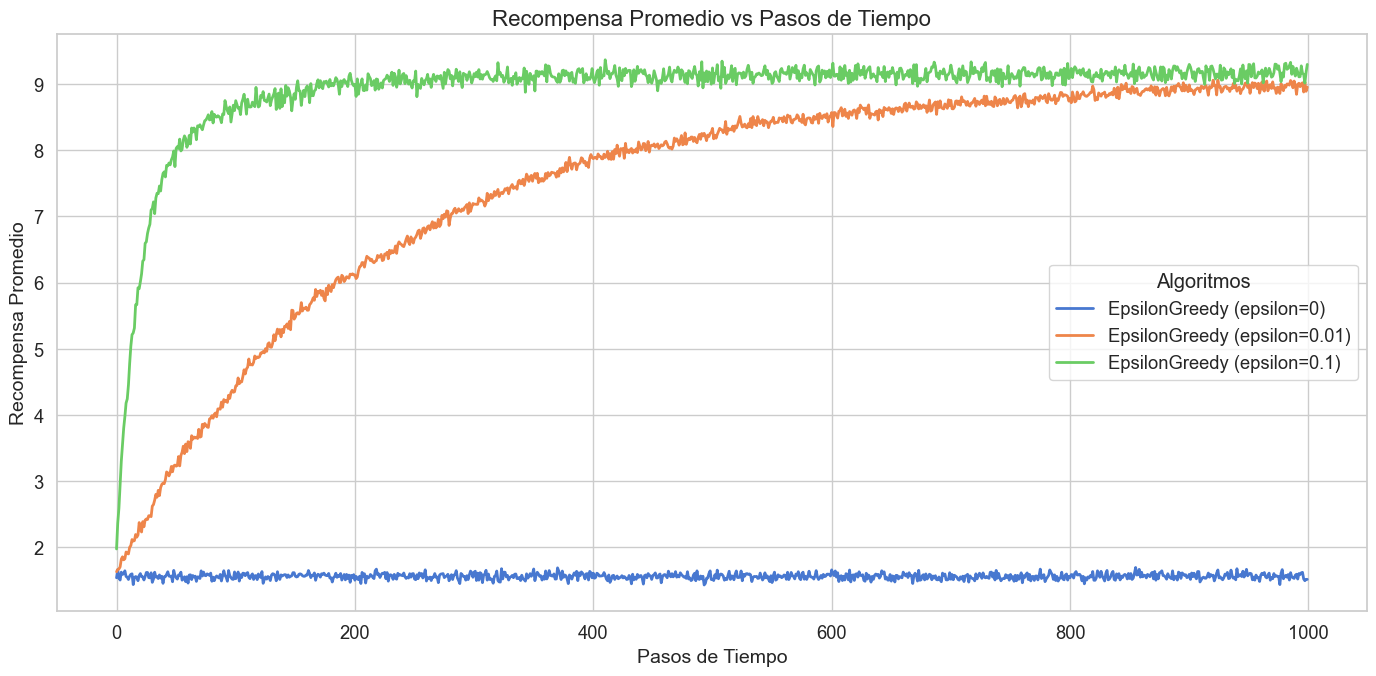

In [ ]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)


#### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno del problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo o steps**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no explotar un mismo brazo y buscar más brazos que puedan maximizar la recompensa.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





#### Evolución Selección Brazo Optimo

Ahora continuamos mostrando la evolución del número de selecciones del brazo óptimo para cada uno de los 3 algoritmos.

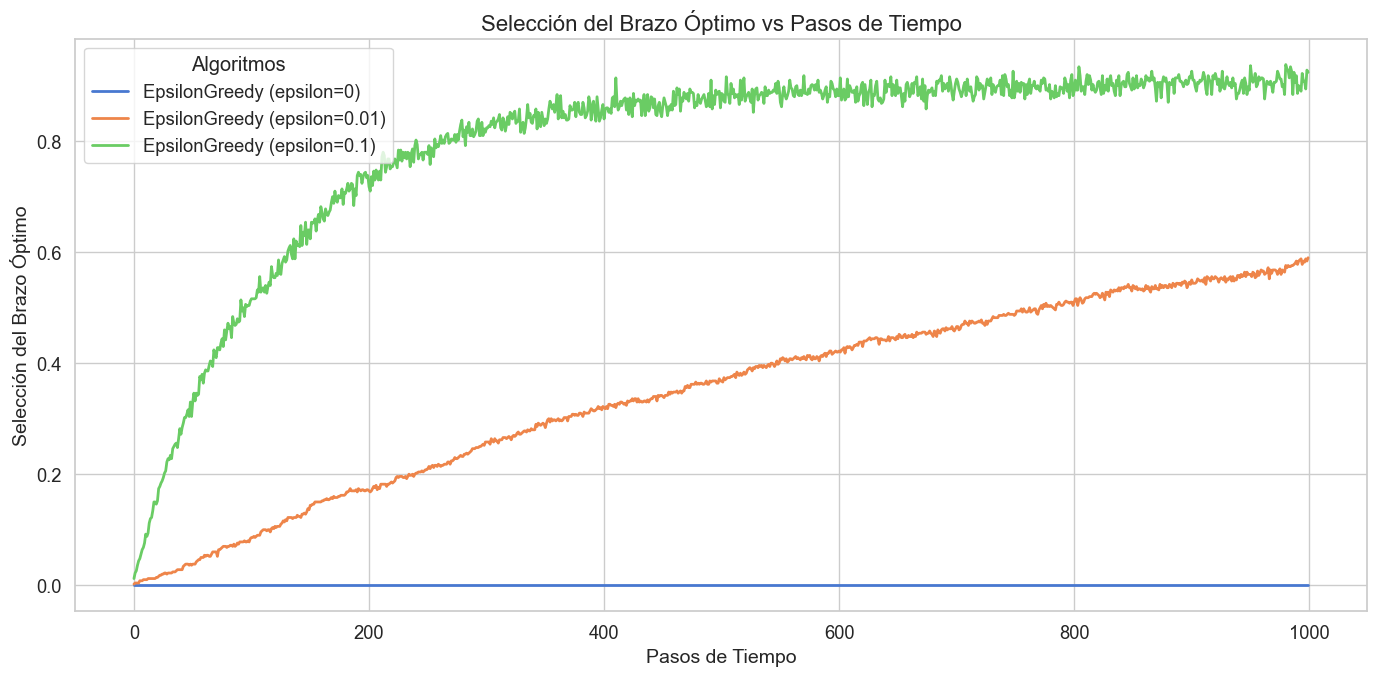

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

#### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado  **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo  en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que será complicado que esta estrategia elija el brazo óptimo a no ser que lo elija en una primera instancia; ya que se dedicara a explotar el brazo elegido inicialmente.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no solo realizar explotación, sino también realizar exploración para encontrar el brazo óptimo.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido cuál es el brazo óptimo y una vez conocido como sabe que es el que mejor recompensa promedio le puede dar, pues comienza a explotar esa opción.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Por lo que tardaría algo más en encontrar el brazo óptimo, pero también lo encontraría y lo comenzaría a explotar aunque más tardamente; haciendo así que tenga un menor número de tiradas de dicho brazo.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones, por lo que nunca tira del brazo optimo y se dedica a explotar el brazo elegido inicialmente.

---

#### Estadisticas de los brazos

c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


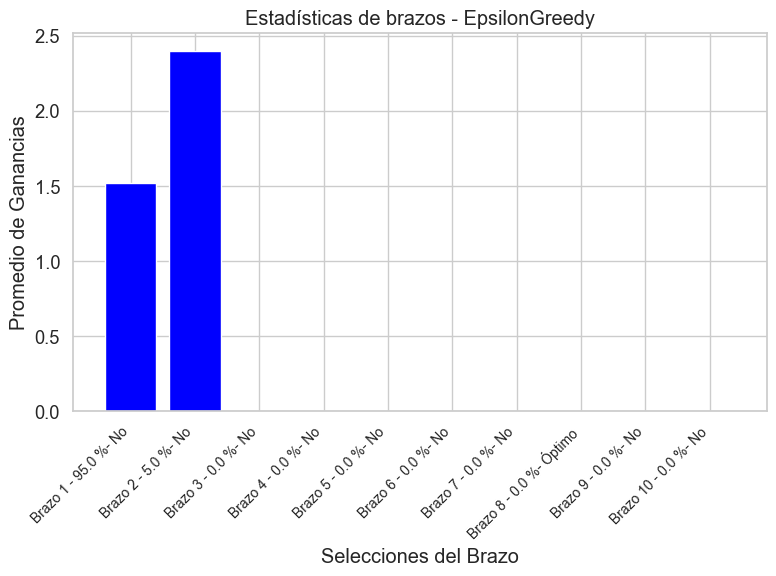

c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


Recompensa Promedio del Brazo 1 : 1.52
Recompensa Promedio del Brazo 2 : 2.4
Recompensa Promedio del Brazo 3 : 0.0
Recompensa Promedio del Brazo 4 : 0.0
Recompensa Promedio del Brazo 5 : 0.0
Recompensa Promedio del Brazo 6 : 0.0
Recompensa Promedio del Brazo 7 : 0.0
Recompensa Promedio del Brazo 8 : 0.0
Recompensa Promedio del Brazo 9 : 0.0
Recompensa Promedio del Brazo 10 : 0.0


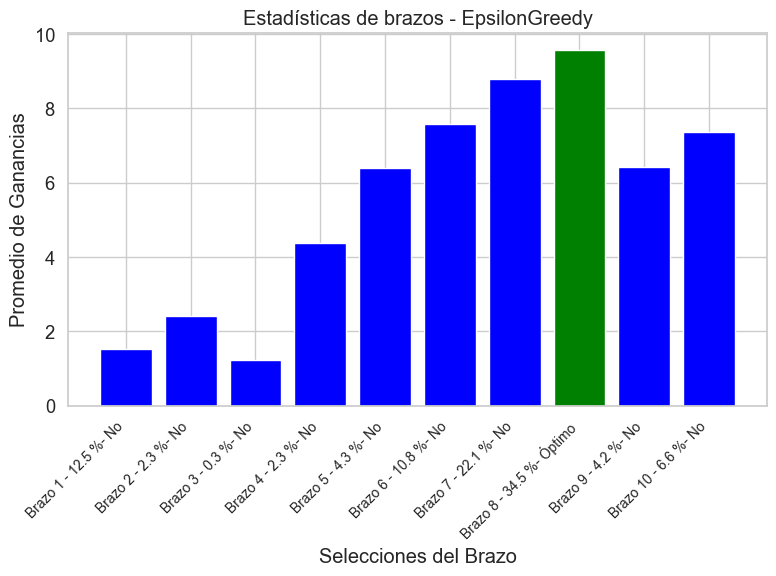

Recompensa Promedio del Brazo 1 : 1.53
Recompensa Promedio del Brazo 2 : 2.4
Recompensa Promedio del Brazo 3 : 1.22
Recompensa Promedio del Brazo 4 : 4.37
Recompensa Promedio del Brazo 5 : 6.4
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.41
Recompensa Promedio del Brazo 10 : 7.37


c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


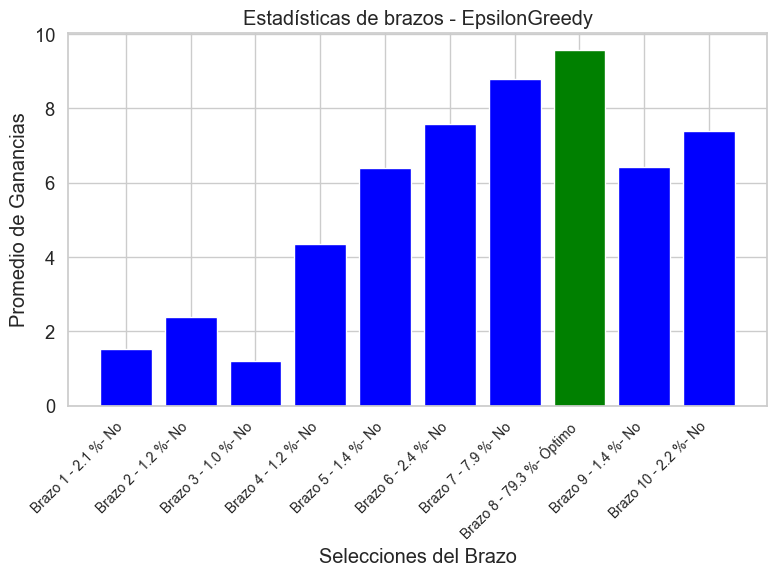

Recompensa Promedio del Brazo 1 : 1.53
Recompensa Promedio del Brazo 2 : 2.39
Recompensa Promedio del Brazo 3 : 1.21
Recompensa Promedio del Brazo 4 : 4.36
Recompensa Promedio del Brazo 5 : 6.4
Recompensa Promedio del Brazo 6 : 7.59
Recompensa Promedio del Brazo 7 : 8.8
Recompensa Promedio del Brazo 8 : 9.56
Recompensa Promedio del Brazo 9 : 6.43
Recompensa Promedio del Brazo 10 : 7.38


In [ ]:
plot_arm_statistics(arm_stats, algorithms)

#### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **ε-Greedy** en el problema del bandido multi-brazo. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de ε en el algoritmo ε-Greedy:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0, por lo que no tendrá ningún componente de exploración.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.01, por lo que tendrá un 1% de probabilidad de exploración.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.1, por lo que tendrá un 10% de probabilidad de exploración, haciendo así que haya un mayor componente de exploración.

2. **Estadísticas brazos**
   - En el primer histograma podemos ver el cómo el algoritmo a no tener exploración siempre se quedara en su primera opción elegida ya es que la mejor recompensa le ha dado hasta el momento. Entre ejecuciones podemos ver como elige entre el brazo 1 o el 2, aunque suele elegir el brazo 1, con un 95% de veces elegido. Como se puede ver ninguno de los 2 es el brazo óptimo. Además podemos ver como de media en las tiradas que sale parece que el brazo 2 da una mejor recompensa promedio.
   - En el segundo histograma ya podemos apreciar la exploración y el cómo se eligen una mayor cantidad de brazos y no se centra en solo explotar uno, podemos darnos cuenta de que alcanza el brazo óptimo que le otorga la mayor recompensa promedio y además es el brazo que una vez encontrado más veces se tiende a elegir dado que es el que mayor recompensa ha dado y que sabe que le seguira dando la recompensa más alta.
   - Ocurre un comportamiento similar al anterior, pero al tener un mayor porcentaje de exploración alcanza antes el brazo óptimo lo que hace que ya lo pueda elegir o explotar más veces al saber que es el brazo con la mayor recompensa que le ha dado. Y eso se ve reflejado en su porcentaje de tiradas promedio.

---

#### Evolución del arrepentimiento promedio.

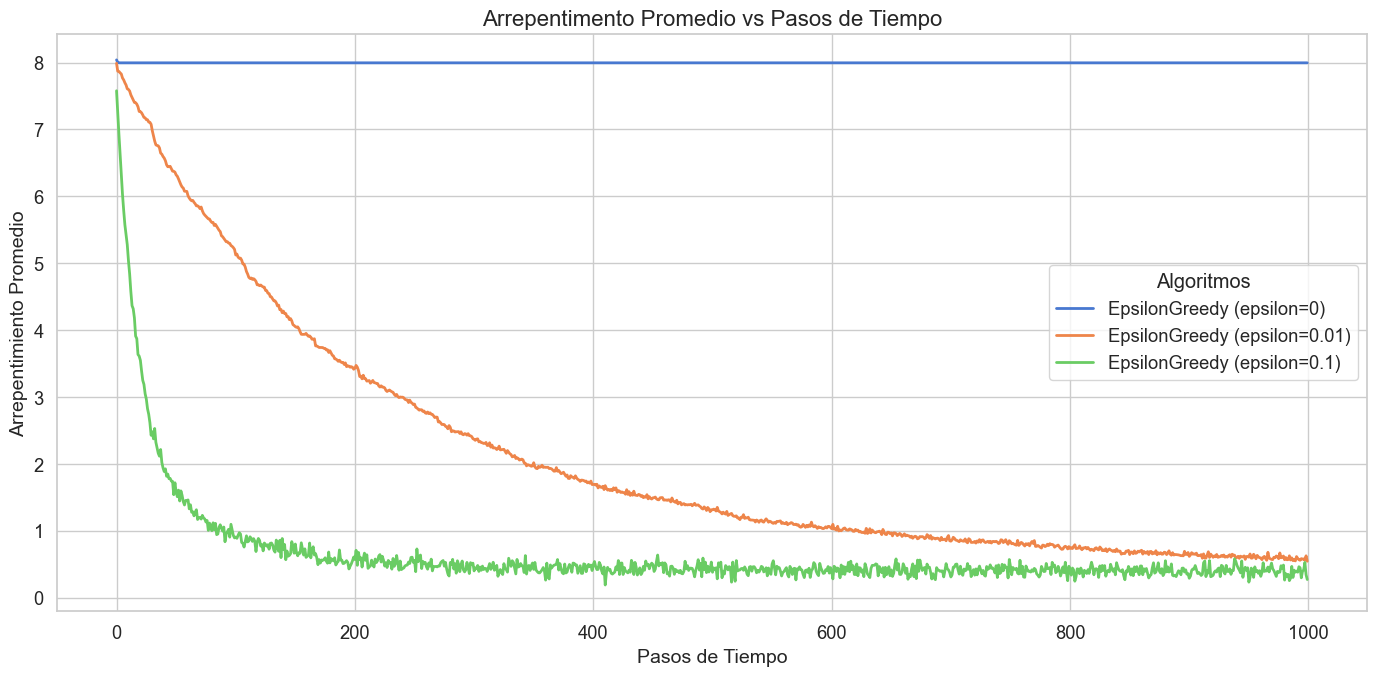

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

#### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico llamado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que esta estrategia difícilmente podría elegir el brazo óptimo a no ser que lo elija de primeras, lo que hará que el arrepentimiento aumente en este algoritmo; ya que al no escogerlo el arrepentimiento no decrecerá hasta que se encuentre el brazo óptimo.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Arrepentimiento promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazo del bandit es óptimo. Esto trae como resultado que rápidamente encuentre el brazo óptimo y por ende empiece a obtener la mejor recompensa, haciendo así que su arrepentimiento decrezca rápidamente hasta estandarizarse en valores mínimos.
   - La línea **naranja (ε=0.01)** también muestra un decrecimiento, pero más lento en comparación con ε=0.1. Esto se debe a que como necesita más tiempo para encontrar el brazo óptimo, pues tirara más veces de brazos que no sean óptimos al tener un menor porcentaje de exploración, haciendo así que aumente el arrepentimiento hasta encontrar el brazo óptimo donde el arrepentimiento comienza a decrecer hasta estandarizarse en valores mínimos.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones. Por lo que se mantiene con un arrepentimiento alto y de manera constante al nunca alcanzar el brazo óptimo.

---

### Conclusiones

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazzo**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandido) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos confirman este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo y comenzar a explotarlo, además obtiene las mejores estadísticas y el arrepentimiento decrece rápidamente.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta y decrecer el arrepentimiento, aunque es cierto que encuentra el brazo óptimo, pero lo explota menos debido a que tarda más en encontrarlo.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima y un arrepentimiento estándar, además tiende a elegir siempre entre el brazo 1 o 2 y como no puede explorar solo se dedica a explotar el que haya elegido lo que le trae estos resultados.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido y un arrepentimiento bajo más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Utilidad Graficos**

El gráfico que nos muestra la recompensa promedio podemos utilizarlo para ver como los algoritmos mejoran en las recompensas obtenidas, para así hacernos a una idea de si están encontrando brazos que otorguen una buena recompensa e inclusive el brazo óptimo. Viendo el balance entre exploración y explotación nos ayuda a entender mejor el algoritmo.

La gráfica de Selección del Brazo Óptimo nos muestra la exploración y explotación, pudiendo ver así si los algoritmos encuentran el brazo óptimo y comienza a explotarlo, si realizan explotación de otros brazos o por ejemplo una falta de exploración para encontrar el brazo óptimo

La gráfica de Estadísticas de Brazos nos muestra una serie de estadísticas de cada brazo como su porcentaje de selecciones, recompensas promedio de cada uno, su nombre o si es óptimo o no. Puede se útil para ver cuanta diferencia en recompensa promedio hay entre los brazos, si está explotando el brazo óptimo u otro brazo, la exploración o el porcentaje de selecciones de cada uno.

La gráfica del Arrepentimiento Promedio nos muestra el arrepentimiento promedio de cada uno de los algoritmos esto es útil, ya que nos ayuda a entender las elecciones de los brazos que están haciendo, si están eligiendo el brazo óptimo o si están explotando un brazo.

Las graficas más relevantes diría que son las 2 primeras. Porque con esas ya podemos hacernos a una idea de si se está seleccionando el brazo óptimo o no, si las recompensas van mejorando o no evolucionan. Entonces con estas 2 podemos básicamente hacernos a una idea de si se está eligiendo buenas opciones e inclusive se puede apreciar la falta de explotación. Las estadísticas de los brazos también es interesante aunque algo menos, lo más significativo para nosotros es el porcentaje de tiradas de cada brazo, ya que se puede apreciar muy fácilmente la explotación y la exploración. La última gráfica aunque interesante realmente no ofrece una información muy novedosa que no hayamos podido obtener con las anteriores.

#### **4. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión para una distribución normal, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

## Distribucion Binomial

### Ejecución del experimento

Volvemos a ejecutar el experimento pero esta vez los brazos seguiran una distribucion binomial.

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(probability=0.37, number=2), ArmBinomial(probability=0.95, number=2), ArmBinomial(probability=0.6, number=2), ArmBinomial(probability=0.73, number=2), ArmBinomial(probability=0.16, number=2), ArmBinomial(probability=0.06, number=2), ArmBinomial(probability=0.87, number=2), ArmBinomial(probability=0.71, number=2), ArmBinomial(probability=0.97, number=2), ArmBinomial(probability=0.02, number=2)
Optimal arm: 9 with expected reward=1.94


### Visualización de los resultados

#### Evolución Recompensa Promedio

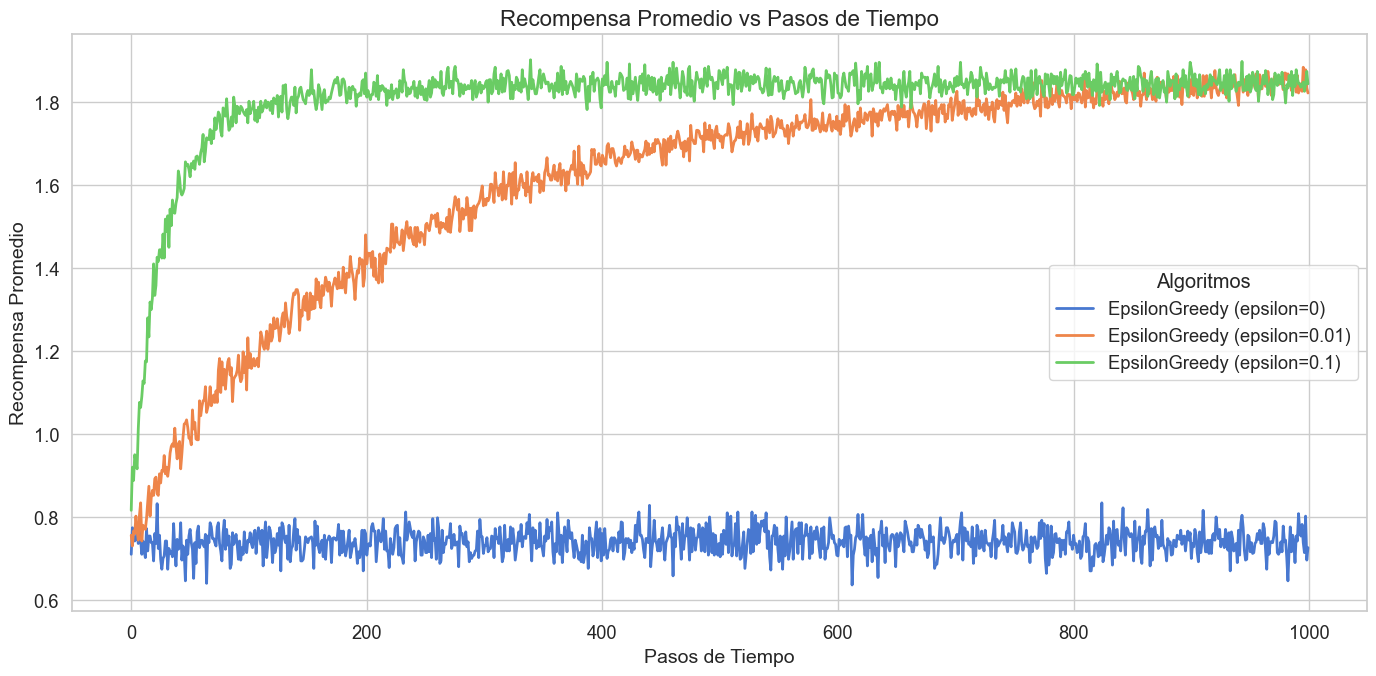

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

### **Análisis detallado de "Recompensa Promedio vs Pasos de Tiempo"**  

El gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"** representa el rendimiento de distintas estrategias del algoritmo **ε-Greedy** en el contexto del problema del bandido multi-brazo. En el eje **x** se muestran los **pasos de tiempo (steps)**, mientras que en el eje **y** se observa la **recompensa promedio** obtenida por cada estrategia aplicada.  

---

### **Diferentes estrategias del algoritmo ε-Greedy:**  
El gráfico incluye tres curvas de distintos colores, cada una correspondiente a un valor diferente de **ε**:  

- **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, lo que significa que siempre selecciona la acción con la mejor recompensa conocida hasta el momento, sin realizar exploraciones.  
- **Naranja (ε = 0.01):** Introduce una probabilidad del **1%** de elegir una acción aleatoria, lo que permite una exploración ocasional para evitar quedar atrapado en una opción subóptima.  
- **Verde (ε = 0.1):** Representa una estrategia más exploratoria, con un **10%** de probabilidad de seleccionar una acción aleatoria, permitiendo una búsqueda más activa de los brazos óptimos.  

---

### **Tendencias en la recompensa promedio:**  
- La **línea verde (ε = 0.1)** muestra un crecimiento rápido en la recompensa promedio, indicando que una estrategia con mayor exploración descubre los mejores brazos con mayor eficiencia.  
- La **línea naranja (ε = 0.01)** también crece progresivamente, aunque de manera más lenta en comparación con **ε = 0.1**. A pesar de esto, eventualmente logra alcanzar un valor similar de recompensa.  
- La **línea azul (ε = 0)** mantiene una recompensa promedio baja, lo que sugiere que la falta de exploración impide identificar el brazo con la mejor recompensa.

Un aspecto a considerar es que las recompensas promedio en este caso son más bajas en comparación con una distribución previa. Esto podría deberse a la forma en que esta nueva distribución genera recompensas, resultando en valores más reducidos en general.

#### Evolución Selección Brazo Optimo

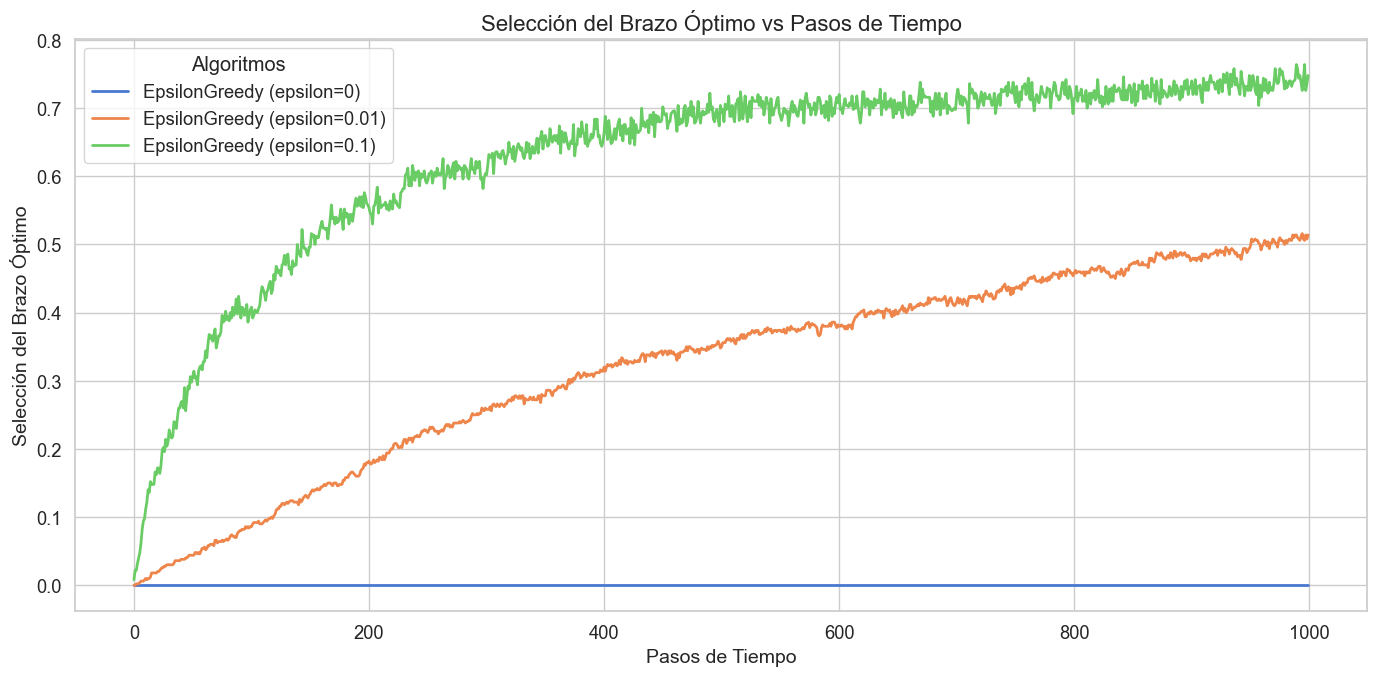

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

### **Análisis detallado de "Selección del Brazo Óptimo vs Pasos de Tiempo"**  

El gráfico titulado **"Selección del Brazo Óptimo vs Pasos de Tiempo"** representa el número de veces promedio que cada estrategia del algoritmo **ε-Greedy** elige el brazo óptimo en el problema del bandido multi-brazo. En el eje **x** se encuentran los **pasos de tiempo**, mientras que en el eje **y** se muestra el **promedio de selecciones del brazo óptimo** para cada algoritmo.  

---

### **Diferentes estrategias del algoritmo ε-Greedy:**  
El gráfico presenta tres curvas de distintos colores, cada una correspondiente a un valor específico de **ε**:  

- **Azul (ε = 0):** Representa una estrategia puramente **explotadora**, lo que significa que siempre selecciona la acción que ha dado la mejor recompensa hasta el momento, sin realizar exploración. Como consecuencia, si no selecciona el brazo óptimo en sus primeras decisiones, se enfocará en explotar la opción inicialmente elegida, sin intentar encontrar una mejor.  
- **Naranja (ε = 0.01):** Introduce una pequeña probabilidad del **1%** de elegir una acción aleatoria, lo que permite una exploración ocasional que ayuda a identificar el brazo óptimo con el tiempo.  
- **Verde (ε = 0.1):** Representa una estrategia con un **10%** de probabilidad de seleccionar acciones aleatorias, facilitando una exploración más amplia del entorno.  

---

### **Tendencias en la selección del brazo óptimo:**  
- La **línea verde (ε = 0.1)** encuentra rápidamente el brazo óptimo, indicando que una estrategia con mayor exploración permite identificarlo con más rapidez. Una vez descubierto, la estrategia lo explota consistentemente, incrementando la frecuencia de selección.  
- La **línea naranja (ε = 0.01)** también muestra una tendencia de crecimiento, aunque de manera más lenta en comparación con **ε = 0.1**. Esto implica que tardará más tiempo en identificar el brazo óptimo y, como resultado, tendrá menos selecciones acumuladas de este en comparación con la estrategia más exploratoria.  
- La **línea azul (ε = 0)**, al no realizar exploración, no encuentra el mejor brazo. Si no lo selecciona desde el inicio, se enfoca en explotar la primera opción elegida, sin posibilidad de descubrir una mejor alternativa.  

Un punto importante a destacar es que, en comparación con una distribución normal, la frecuencia promedio de selección del brazo óptimo es menor. Esto podría deberse a la aleatoriedad inherente de la exploración, lo que dificulta tanto el inicio del proceso de exploración como la identificación precisa del mejor brazo.

#### Estadisticas de los brazos

c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


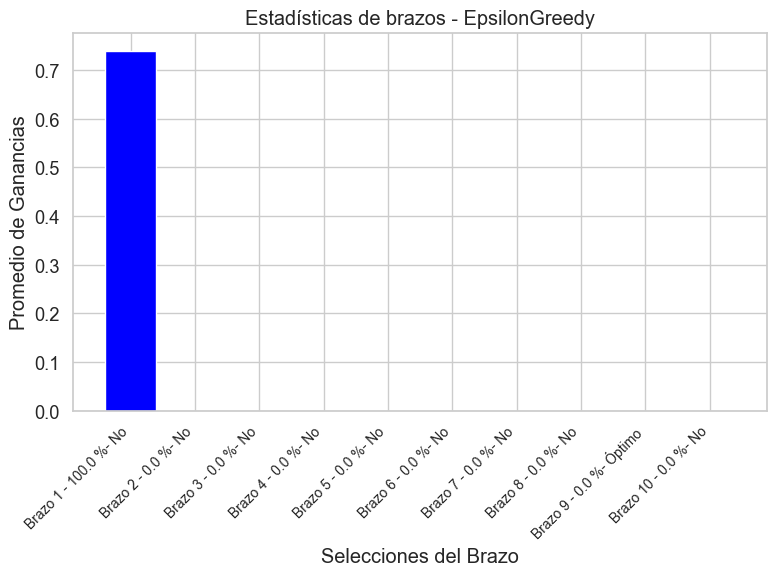

Recompensa Promedio del Brazo 1 : 0.74
Recompensa Promedio del Brazo 2 : 0.0
Recompensa Promedio del Brazo 3 : 0.0
Recompensa Promedio del Brazo 4 : 0.0
Recompensa Promedio del Brazo 5 : 0.0
Recompensa Promedio del Brazo 6 : 0.0
Recompensa Promedio del Brazo 7 : 0.0
Recompensa Promedio del Brazo 8 : 0.0
Recompensa Promedio del Brazo 9 : 0.0
Recompensa Promedio del Brazo 10 : 0.0


c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


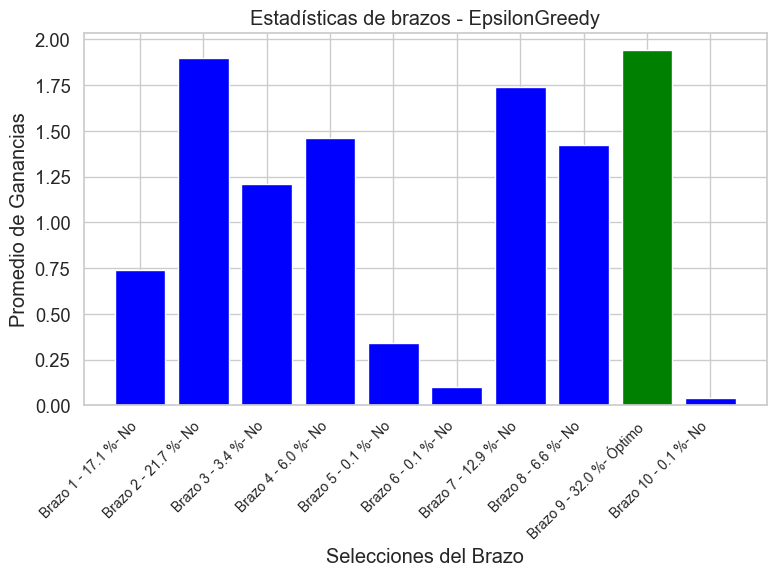

Recompensa Promedio del Brazo 1 : 0.74
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.21
Recompensa Promedio del Brazo 4 : 1.46
Recompensa Promedio del Brazo 5 : 0.34
Recompensa Promedio del Brazo 6 : 0.1
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.42
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


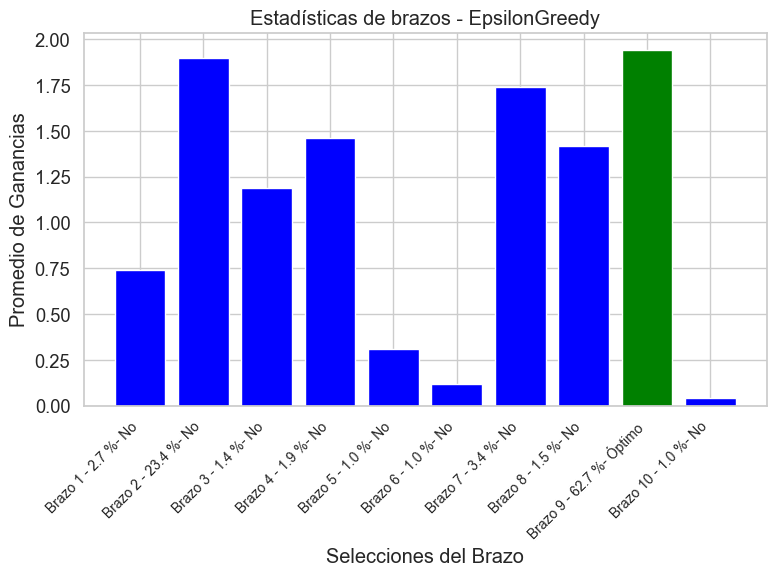

Recompensa Promedio del Brazo 1 : 0.74
Recompensa Promedio del Brazo 2 : 1.9
Recompensa Promedio del Brazo 3 : 1.19
Recompensa Promedio del Brazo 4 : 1.46
Recompensa Promedio del Brazo 5 : 0.31
Recompensa Promedio del Brazo 6 : 0.12
Recompensa Promedio del Brazo 7 : 1.74
Recompensa Promedio del Brazo 8 : 1.42
Recompensa Promedio del Brazo 9 : 1.94
Recompensa Promedio del Brazo 10 : 0.04


In [ ]:
plot_arm_statistics(arm_stats, algorithms)

### **Análisis detallado de "Estadísticas de los Brazos"**  

Las imágenes presentan un histograma donde se analizan diversas estadísticas de los brazos en el contexto del problema del bandido multi-brazo utilizando el algoritmo **ε-Greedy**. Entre las estadísticas mostradas se incluyen la **recompensa promedio**, el **número de veces que ha sido seleccionado cada brazo**, si el **brazo es óptimo**, y el **número de identificación de cada brazo**.  

---

### **Tres histogramas según los valores de ε en el algoritmo ε-Greedy:**  
Cada histograma representa las estadísticas de los brazos bajo un valor distinto de **ε**, lo que influye en el grado de exploración del algoritmo:  

- **Primer histograma (ε = 0):** No existe componente de exploración, por lo que el algoritmo se basa únicamente en explotación.  
- **Segundo histograma (ε = 0.01):** Introduce un **1% de probabilidad de exploración**, lo que permite probar otros brazos en ciertas ocasiones.  
- **Tercer histograma (ε = 0.1):** Aumenta la probabilidad de exploración al **10%**, lo que favorece un descubrimiento más rápido del brazo óptimo.  

---

### **Patrones observados en las estadísticas de los brazos:**  
- En el **primer histograma (ε = 0)**, al no haber exploración, el algoritmo se aferra al primer brazo seleccionado que haya proporcionado la mejor recompensa inicial. Como resultado, en todas las ejecuciones el algoritmo tiende a explotar esa primera elección sin buscar opciones mejores.  
- En el **segundo histograma (ε = 0.01)**, ya es evidente la exploración, lo que se traduce en una mayor cantidad de brazos seleccionados en comparación con el caso anterior. Esto permite encontrar el **brazo óptimo**, el cual otorga la **mayor recompensa promedio** y, una vez identificado, es el que más veces se elige debido a su superioridad en rendimiento.  
- En el **tercer histograma (ε = 0.1)**, se observa un comportamiento similar al del segundo, pero con un **aprendizaje más rápido** del brazo óptimo debido a la mayor tasa de exploración. Como consecuencia, el algoritmo encuentra antes el mejor brazo y comienza a explotarlo con más frecuencia, lo que se refleja en un **mayor porcentaje de selecciones promedio** del brazo óptimo.  

Un aspecto interesante es que en esta configuración del problema, el **brazo óptimo corresponde al número 9**, mientras que en una distribución anterior era el **brazo 8**. Este cambio podría explicar por qué la recompensa y la frecuencia de selección del brazo óptimo fueron menores. Al encontrarse más alejado en el índice de brazos, su descubrimiento podría resultar más desafiante durante la exploración. Además, la recompensa promedio del **brazo óptimo no es significativamente superior a la de otros brazos**, lo que también podría dificultar su identificación durante el proceso de aprendizaje.

#### Evolución del arrepentimiento promedio.

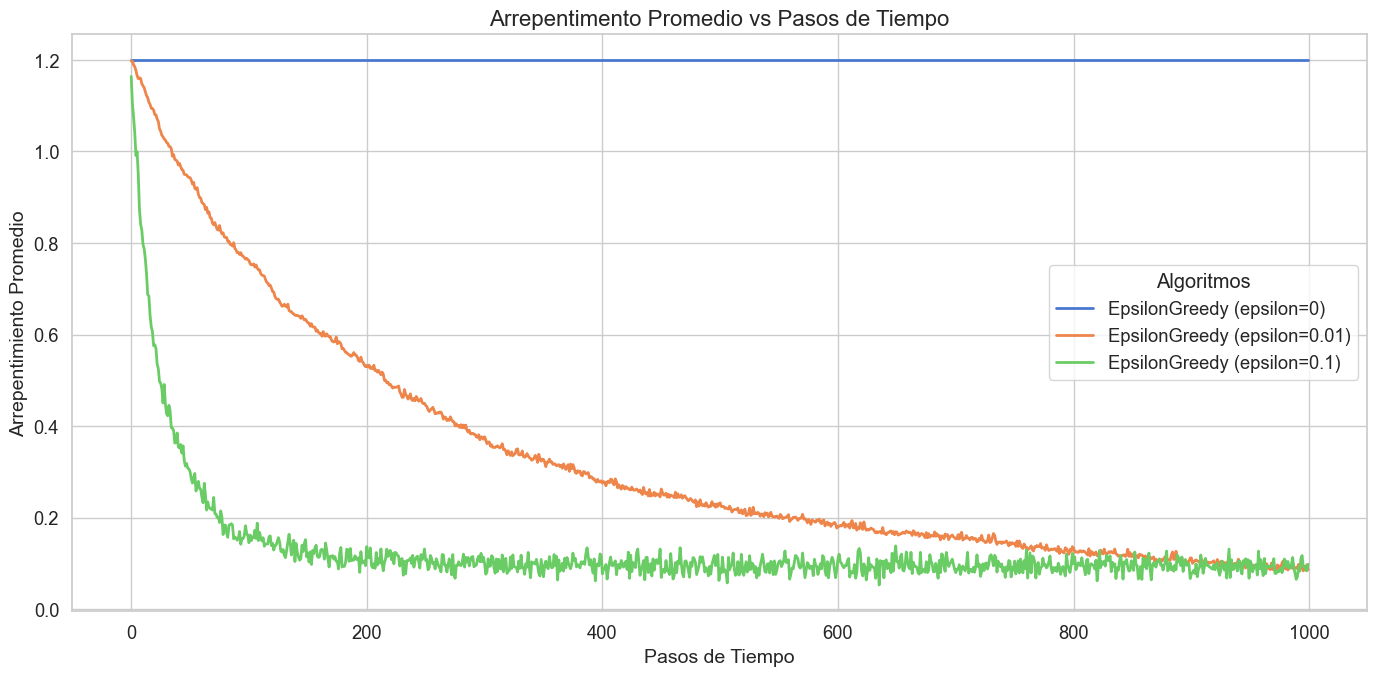

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

### **Análisis detallado de "Arrepentimiento Promedio vs Pasos de Tiempo"**  

El gráfico titulado **"Arrepentimiento Promedio vs Pasos de Tiempo"** muestra el comportamiento del **arrepentimiento promedio** en función del tiempo para distintas estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se encuentran los **pasos de tiempo**, mientras que en el eje **y** se observa el **arrepentimiento promedio** de cada algoritmo.  

---

### **Diferentes estrategias del algoritmo ε-Greedy:**  
El gráfico presenta tres curvas de distintos colores, cada una correspondiente a un valor específico de **ε**, lo que influye en el balance entre exploración y explotación:  

- **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, que siempre selecciona la acción con la mejor recompensa conocida hasta el momento sin explorar otras opciones. Debido a esta falta de exploración, si no elige el brazo óptimo desde el inicio, continuará explotando un brazo subóptimo, lo que genera un **arrepentimiento acumulado** que se mantiene alto y constante.  
- **Naranja (ε = 0.01):** Introduce una probabilidad del **1%** de seleccionar una acción aleatoria, permitiendo algo de exploración y aumentando las posibilidades de encontrar el brazo óptimo con el tiempo.  
- **Verde (ε = 0.1):** Con un **10%** de exploración, esta estrategia tiene una mayor probabilidad de descubrir rápidamente el mejor brazo y reducir su arrepentimiento.  

---

### **Tendencias en el arrepentimiento promedio:**  
- La **línea verde (ε = 0.1)** desciende rápidamente, lo que indica que la estrategia encuentra el brazo óptimo en menos tiempo. Al identificarlo pronto, comienza a explotarlo, reduciendo el arrepentimiento hasta estabilizarlo en valores mínimos.  
- La **línea naranja (ε = 0.01)** también muestra una disminución del arrepentimiento, aunque más lenta en comparación con **ε = 0.1**. Dado que explora menos, tarda más en encontrar el brazo óptimo y acumula más arrepentimiento en el proceso. Sin embargo, una vez que lo descubre, su arrepentimiento comienza a decrecer hasta estabilizarse.  
- La **línea azul (ε = 0)** mantiene un **arrepentimiento alto y constante** a lo largo del tiempo. Esto ocurre porque, al no explorar, no logra identificar el mejor brazo y se queda atrapado en la explotación de una opción subóptima, sin reducir su arrepentimiento.  

Estos resultados confirman que una mayor exploración inicial ayuda a encontrar antes el brazo óptimo, lo que permite reducir rápidamente el arrepentimiento y alcanzar un rendimiento más eficiente en el tiempo.

### **Conclusiones**  

Hemos analizado un **experimento de toma de decisiones secuenciales**, modelado con un **Bandido Multi-Brazo**, un problema clave en el aprendizaje por refuerzo y la teoría de decisiones. En este estudio, nos hemos centrado exclusivamente en el algoritmo **ε-Greedy**, extrayendo las siguientes conclusiones a partir de los resultados y gráficos obtenidos:  

---

### **1. Equilibrio entre Exploración y Explotación**  
El algoritmo **ε-Greedy** debe encontrar un balance entre **explorar nuevas opciones** y **explotar las mejores opciones conocidas**:  
- **Explotación (ε=0):** Se enfoca únicamente en la mejor opción conocida sin explorar otras alternativas. Si inicialmente selecciona un brazo subóptimo, continuará eligiéndolo indefinidamente sin descubrir opciones más rentables.  
- **Exploración (ε>0):** Introduce aleatoriedad para descubrir nuevas opciones con mejores recompensas.  

Los gráficos reflejan este comportamiento de manera clara:  
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio y reduce el arrepentimiento rápidamente, ya que explora lo suficiente como para encontrar pronto el mejor brazo y luego explotarlo eficientemente.  
- **ε=0.01 (naranja)** tarda más en encontrar el brazo óptimo debido a su menor exploración, por lo que su recompensa crece más lentamente y el arrepentimiento disminuye de forma más gradual.  
- **ε=0 (azul)** nunca explora, lo que lo deja atrapado en una recompensa subóptima y un arrepentimiento alto y constante. Además, tiende a seleccionar los primeros brazos explorados sin considerar si son realmente los mejores.  

---

### **2. Convergencia de los Algoritmos**  
Los algoritmos con mayor exploración (**ε=0.1**) logran **converger más rápido** hacia una recompensa alta y un arrepentimiento bajo porque:  
- Inicialmente, no tienen suficiente información sobre cuál es el mejor brazo.  
- A medida que exploran, identifican el brazo óptimo y comienzan a explotarlo más.  
- Un balance adecuado entre exploración y explotación es crucial para optimizar la recompensa a largo plazo.  

---

### **3. Utilidad de los Gráficos**  

Cada gráfico ofrece información clave sobre el rendimiento de los algoritmos:  

- **Recompensa Promedio vs Pasos de Tiempo:** Permite evaluar si los algoritmos están aprendiendo a elegir brazos con mejores recompensas y si están encontrando el brazo óptimo. Muestra la evolución del balance entre exploración y explotación.  
- **Selección del Brazo Óptimo vs Pasos de Tiempo:** Indica si los algoritmos encuentran el brazo óptimo y comienzan a explotarlo. También refleja el grado de exploración y la falta de explotación en ciertos casos.  
- **Estadísticas de los Brazos:** Muestra información detallada sobre cada brazo, como su porcentaje de selecciones y su recompensa promedio. Ayuda a analizar la diferencia entre los brazos y la efectividad de la exploración.  
- **Arrepentimiento Promedio vs Pasos de Tiempo:** Refleja cuán eficientemente los algoritmos están encontrando y explotando el brazo óptimo. Aunque es interesante, no aporta información completamente nueva en comparación con los gráficos de recompensa y selección del brazo óptimo.  

Las **dos primeras gráficas** son las más relevantes, ya que permiten identificar rápidamente si los algoritmos están mejorando sus elecciones y si han logrado encontrar el mejor brazo. Las **estadísticas de los brazos** también son útiles, pero el arrepentimiento promedio no aporta información novedosa que no se pueda inferir de los otros gráficos.  

---

### **4. Aplicaciones y Reflexiones Finales**  
- En problemas de toma de decisiones **(ejemplo: sistemas de recomendación, publicidad, medicina personalizada, optimización de inversiones)**, una exploración moderada **(ε=0.1)** suele ser más efectiva para encontrar la mejor opción rápidamente.  
- **La falta de exploración (ε=0)** conduce a un rendimiento deficiente, ya que el agente puede quedar atrapado en una elección subóptima.  
- En esta distribución, el **brazo óptimo es más difícil de encontrar**, lo que impacta el rendimiento de los algoritmos en comparación con distribuciones anteriores.  

En conclusión, para una distribución binomial, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el desempeño del algoritmo en entornos de aprendizaje por refuerzo.** 🚀

## Distribución Bernoulli

### Ejecución del experimento

Ahora continuamos con la distribución de Bernoulli

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBenoulli(p=0.37), ArmBenoulli(p=0.95), ArmBenoulli(p=0.6), ArmBenoulli(p=0.73), ArmBenoulli(p=0.16), ArmBenoulli(p=0.06), ArmBenoulli(p=0.87), ArmBenoulli(p=0.71), ArmBenoulli(p=0.97), ArmBenoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


### Visualización de los resultados

#### Evolución Recompensa Promedio

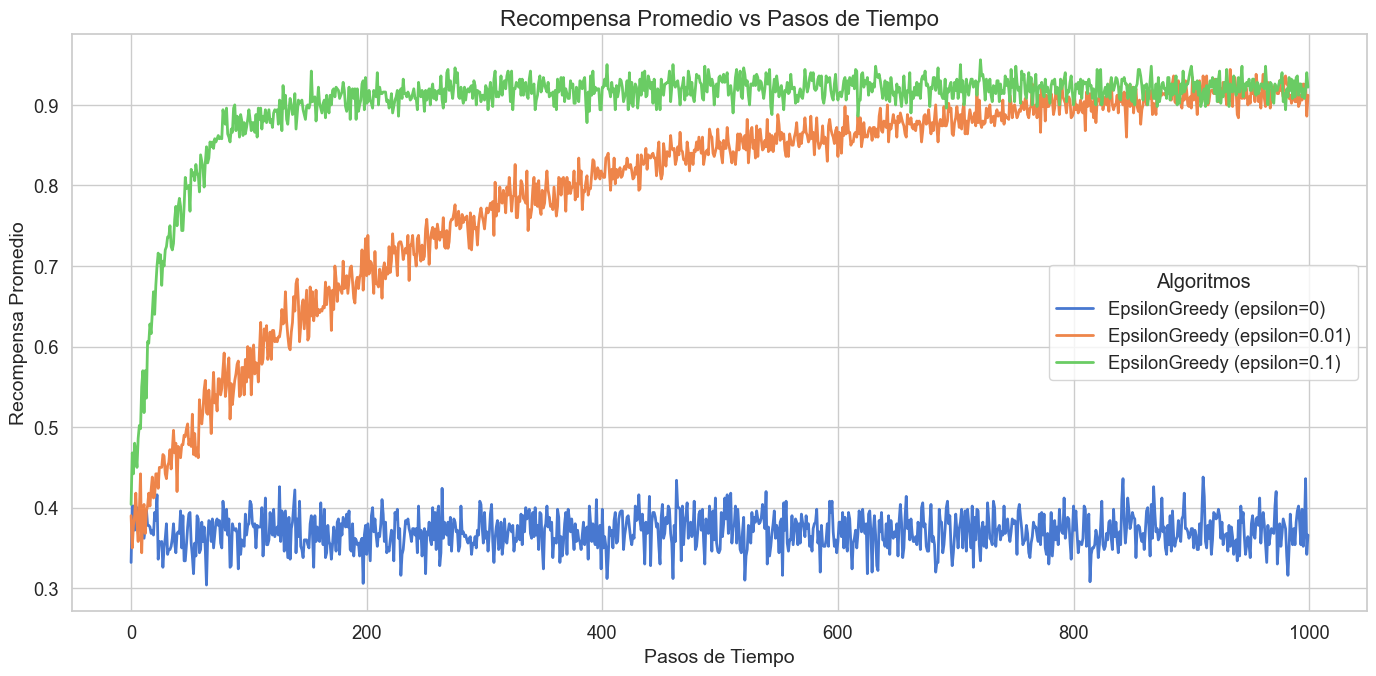

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

### **Análisis detallado de "Recompensa Promedio vs Pasos de Tiempo"**  

El gráfico titulado **"Recompensa Promedio vs Pasos de Tiempo"** analiza el desempeño del algoritmo **ε-Greedy** en el problema del bandido multi-brazo. En el eje **x** se representan los **pasos de tiempo (steps)**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada estrategia a lo largo del tiempo.  

---

### **1. Comparación de Estrategias con Diferentes Valores de ε**  
El gráfico presenta tres líneas de diferentes colores, cada una representando una configuración distinta del algoritmo **ε-Greedy**:  

- **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, que siempre elige la mejor opción conocida sin explorar otras alternativas. Como resultado, si inicialmente selecciona un brazo subóptimo, continuará eligiéndolo sin descubrir opciones mejores.  
- **Naranja (ε = 0.01):** Introduce un pequeño componente de exploración (1%), lo que permite que el algoritmo busque nuevas opciones antes de decidir cuál es la mejor. Esto evita que se quede atrapado en una elección temprana que no sea óptima.  
- **Verde (ε = 0.1):** Aumenta la exploración al 10%, lo que significa que el algoritmo explora más frecuentemente, ayudándolo a encontrar el mejor brazo más rápido.  

---

### **2. Evolución de la Recompensa Promedio**  
El comportamiento de cada estrategia se refleja en la evolución de la recompensa promedio en el tiempo:  

- **ε=0.1 (verde)** logra alcanzar una recompensa alta rápidamente, indicando que la exploración activa le permite identificar el mejor brazo y explotarlo con eficacia.  
- **ε=0.01 (naranja)** también muestra un aumento en la recompensa, pero de manera más lenta en comparación con **ε=0.1**, ya que la menor exploración implica que tarda más en encontrar el brazo óptimo.  
- **ε=0 (azul)** mantiene una recompensa baja y estable a lo largo del tiempo, lo que sugiere que no logra identificar el mejor brazo debido a la falta de exploración.  

Dado que la distribución binomial puede considerarse una generalización de la distribución de Bernoulli, los resultados observados en este gráfico son similares a los de experimentos con distribuciones Bernoulli.  

---  

En resumen, **el nivel de exploración influye directamente en la rapidez con la que el algoritmo encuentra la mejor opción y maximiza la recompensa**. Un balance adecuado entre exploración y explotación es clave para optimizar el aprendizaje en problemas de toma de decisiones secuenciales. 🚀

#### Evolución Selección Brazo Optimo


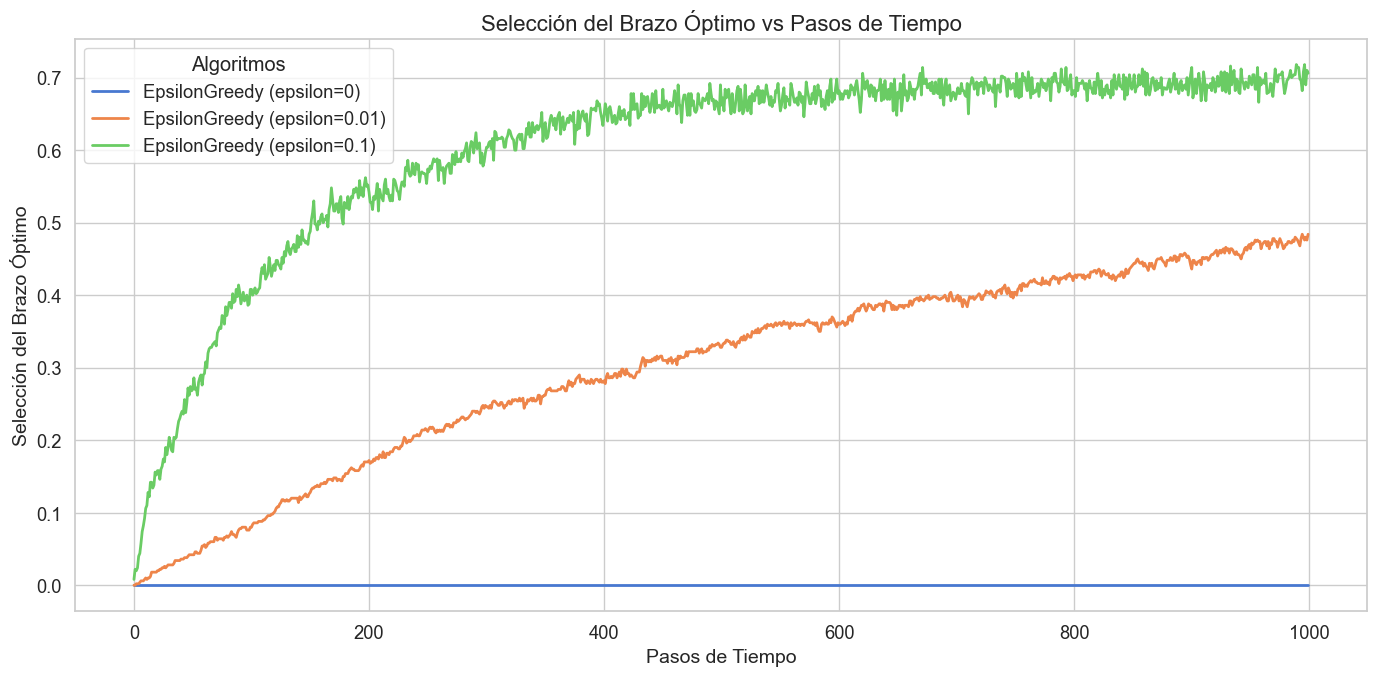

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

### **Análisis detallado de "Selección del Brazo Óptimo vs Pasos de Tiempo"**  

El gráfico titulado **"Selección del Brazo Óptimo vs Pasos de Tiempo"** muestra el comportamiento de diferentes estrategias del algoritmo **ε-Greedy** en términos de la cantidad de veces que seleccionan el brazo óptimo en el problema del bandido multi-brazo.  

- En el eje **x**, se representan los **pasos de tiempo**.  
- En el eje **y**, se muestra el **promedio de selecciones del brazo óptimo** por cada estrategia.  

---

### **1. Comparación de Estrategias con Diferentes Valores de ε**  
El gráfico presenta tres líneas de diferentes colores, cada una representando una configuración distinta del algoritmo **ε-Greedy**:  

- **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, que solo elige la opción que ha dado la mejor recompensa hasta el momento sin explorar otras posibilidades. Esto significa que si inicialmente no elige el brazo óptimo, nunca lo descubrirá.  
- **Naranja (ε = 0.01):** Introduce una exploración mínima (1%), lo que permite que el algoritmo busque nuevas opciones y eventualmente encuentre el brazo óptimo, aunque de manera más lenta.  
- **Verde (ε = 0.1):** Aumenta la exploración al 10%, lo que le ayuda a identificar el brazo óptimo más rápido y, una vez encontrado, a explotarlo con mayor frecuencia.  

---

### **2. Evolución de la Selección del Brazo Óptimo**  
El comportamiento de cada estrategia se refleja en la cantidad de veces que el algoritmo selecciona el brazo óptimo a lo largo del tiempo:  

- **ε=0.1 (verde)** encuentra el brazo óptimo rápidamente gracias a su mayor tasa de exploración y, una vez identificado, comienza a explotarlo consistentemente. Sin embargo, en este experimento parece que hay una leve reducción en la frecuencia de selección del brazo óptimo en comparación con pruebas previas.  
- **ε=0.01 (naranja)** también alcanza el brazo óptimo, pero de manera más lenta. Su menor tasa de exploración hace que tarde más en encontrarlo, lo que resulta en un menor número de selecciones del brazo óptimo en comparación con **ε=0.1**.  
- **ε=0 (azul)**, al no explorar, no logra encontrar el mejor brazo a menos que lo elija desde el inicio. Como resultado, su número de selecciones del brazo óptimo es significativamente es nula.

Un detalle interesante es que, en esta prueba, **ε=0.1 no selecciona el brazo óptimo tantas veces como en experimentos previos**, lo que puede deberse a la aleatoriedad de la exploración o a la semilla utilizada en el experimento.  

---

### **Conclusión**  
El nivel de exploración es fundamental para encontrar el brazo óptimo en el menor tiempo posible. **Un valor de ε=0.1 permite un aprendizaje más rápido y eficiente**, mientras que **ε=0.01** lo encuentra más lentamente y **ε=0**  nunca lo identifica. Este resultado refuerza la importancia de equilibrar exploración y explotación en problemas de toma de decisiones secuenciales. 🚀

#### Estadisticas de los brazos

c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


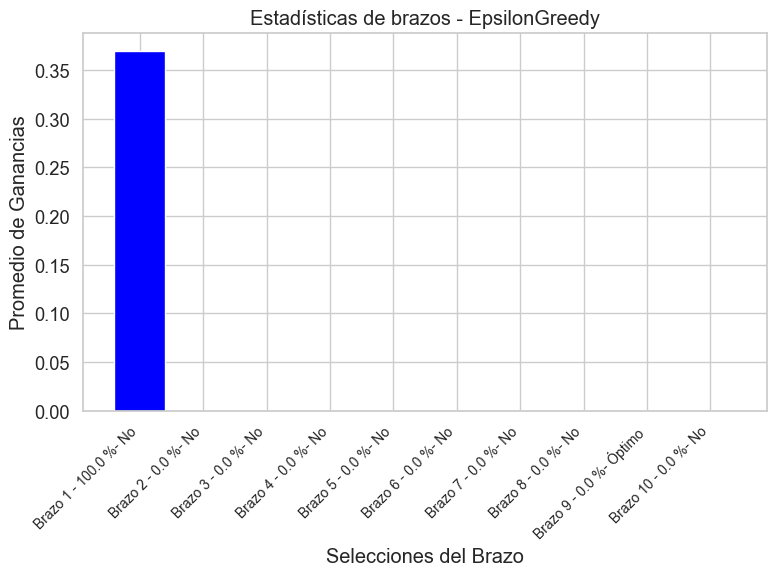

c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


Recompensa Promedio del Brazo 1 : 0.37
Recompensa Promedio del Brazo 2 : 0.0
Recompensa Promedio del Brazo 3 : 0.0
Recompensa Promedio del Brazo 4 : 0.0
Recompensa Promedio del Brazo 5 : 0.0
Recompensa Promedio del Brazo 6 : 0.0
Recompensa Promedio del Brazo 7 : 0.0
Recompensa Promedio del Brazo 8 : 0.0
Recompensa Promedio del Brazo 9 : 0.0
Recompensa Promedio del Brazo 10 : 0.0


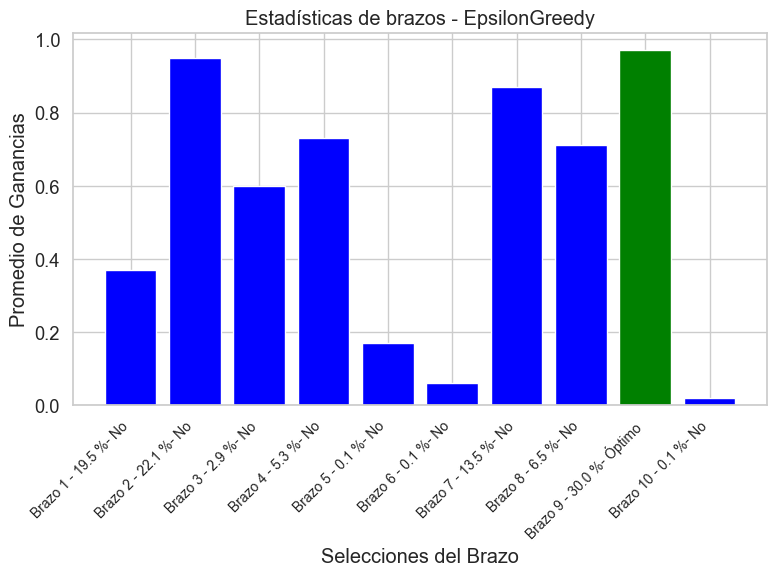

Recompensa Promedio del Brazo 1 : 0.37
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.6
Recompensa Promedio del Brazo 4 : 0.73
Recompensa Promedio del Brazo 5 : 0.17
Recompensa Promedio del Brazo 6 : 0.06
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


c:\Users\Usuario\Desktop\bandit\bandit\plotting\plotting.py:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


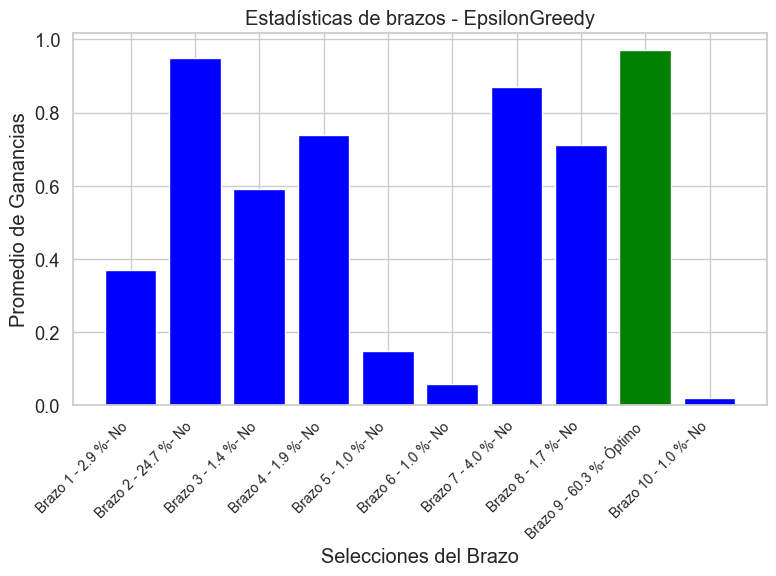

Recompensa Promedio del Brazo 1 : 0.37
Recompensa Promedio del Brazo 2 : 0.95
Recompensa Promedio del Brazo 3 : 0.59
Recompensa Promedio del Brazo 4 : 0.74
Recompensa Promedio del Brazo 5 : 0.15
Recompensa Promedio del Brazo 6 : 0.06
Recompensa Promedio del Brazo 7 : 0.87
Recompensa Promedio del Brazo 8 : 0.71
Recompensa Promedio del Brazo 9 : 0.97
Recompensa Promedio del Brazo 10 : 0.02


In [ ]:
plot_arm_statistics(arm_stats, algorithms)

### **Análisis detallado de "Estadísticas de los Brazos"**  

Las imágenes muestran un **histograma** con las estadísticas de los brazos en el problema del bandido multi-brazo, utilizando diferentes valores de **ε** en el algoritmo **ε-Greedy**. Estos histogramas permiten analizar diversas métricas, como:  

- **Recompensa promedio de cada brazo**  
- **Número de veces que ha sido seleccionado cada brazo**  
- **Identificación del brazo óptimo**  
- **Distribución de selecciones entre los brazos**  

---

### **1. Comparación entre los Histogramas de Diferentes Valores de ε**  
El análisis incluye tres histogramas, cada uno correspondiente a un valor diferente de **ε**:  

- **Primer histograma (ε = 0):** Representa el caso sin exploración. El algoritmo solo explota el primer brazo que haya elegido inicialmente como el mejor.  
- **Segundo histograma (ε = 0.01):** Introduce una ligera exploración (1%), lo que permite que el algoritmo pruebe diferentes brazos antes de concentrarse en el mejor.  
- **Tercer histograma (ε = 0.1):** Aumenta la exploración al 10%, lo que permite encontrar el brazo óptimo más rápidamente y maximizar su selección.  

---

### **2. Comportamiento de la Selección de los Brazos**  
El análisis de los histogramas nos permite ver cómo la estrategia de exploración afecta la elección de los brazos:  

- **ε = 0 (primer histograma):**  
  - Al no haber exploración, el algoritmo selecciona **un único brazo constantemente**, que puede no ser el óptimo.
  - Al no tener exploracion solo se explota el brazo inicial elegido.
  - La recompensa promedio de este brazo es menor en comparación con las estrategias exploratorias.  

- **ε = 0.01 (segundo histograma):**  
  - Se observa un mayor número de brazos explorados antes de que el algoritmo converja en la mejor opción.  
  - El brazo óptimo es identificado y seleccionado con mayor frecuencia que en **ε = 0**.  

- **ε = 0.1 (tercer histograma):**  
  - El brazo óptimo se encuentra más rápido debido a la mayor exploración, lo que permite que el algoritmo lo seleccione con más frecuencia.  


---

### **3. Conclusión**  
Los histogramas confirman que una mayor exploración inicial permite encontrar y explotar el **brazo óptimo** más rápidamente. **ε = 0.1 es la estrategia más eficiente**, ya que alcanza antes el brazo óptimo y obtiene la mejor recompensa promedio.  

En comparación con experimentos previos, los resultados son similares, con ligeras variaciones debido a la aleatoriedad del proceso. 📊

#### Evolución del arrepentimiento promedio.

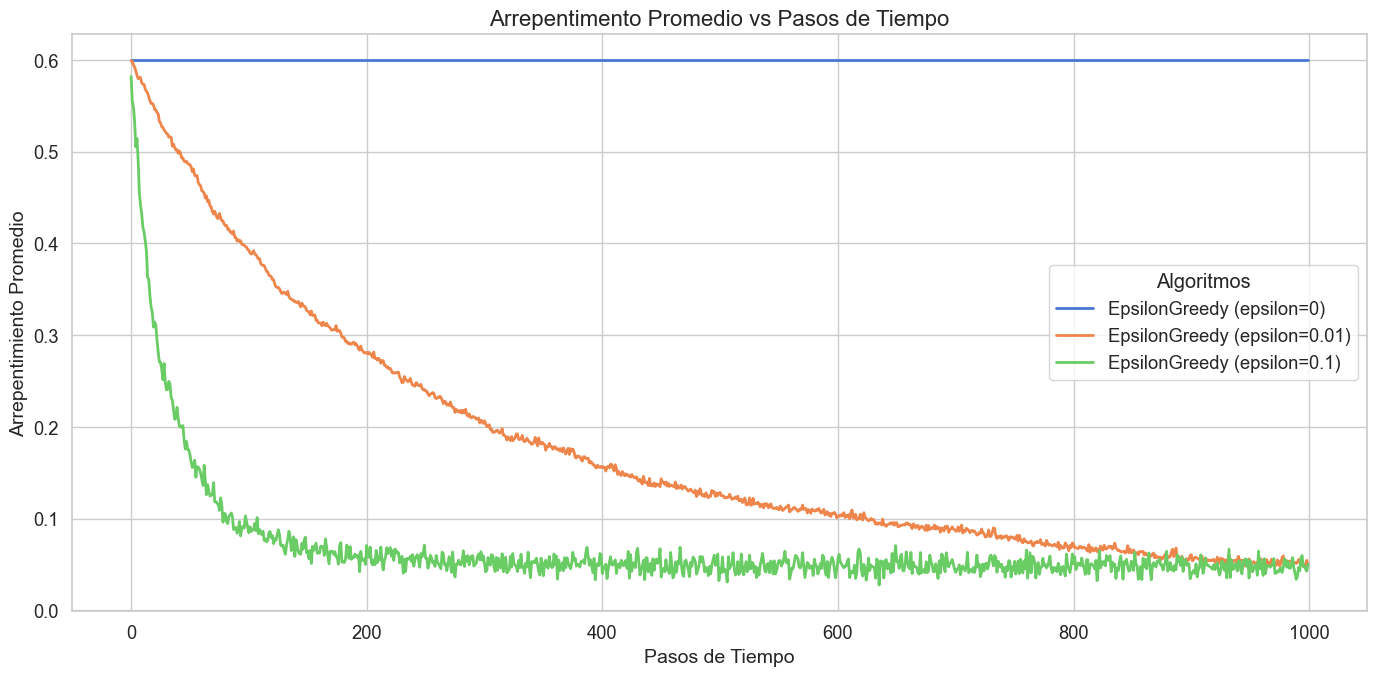

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

### **Análisis detallado de "Arrepentimiento Promedio vs Pasos de Tiempo"**  

La imagen muestra un gráfico titulado **"Arrepentimiento Promedio vs Pasos de Tiempo"**, en el que se analiza el rendimiento de diferentes estrategias del algoritmo **ε-Greedy** en el problema del bandido multi-brazo.  

- **Eje X:** Representa los **pasos de tiempo** (steps).  
- **Eje Y:** Muestra el **arrepentimiento promedio**, que mide la diferencia entre la recompensa máxima posible y la obtenida por el algoritmo en cada paso.  

---

### **1. Comparación entre los Diferentes Valores de ε**  
El gráfico presenta tres líneas de colores, cada una representando un valor diferente de **ε** en el algoritmo **ε-Greedy**:  

- **Azul (ε = 0):**  
  - No tiene exploración, por lo que selecciona siempre el primer brazo con mejor recompensa inicial.  
  - Si ese brazo no es el óptimo, el algoritmo nunca lo descubrirá, manteniendo un **arrepentimiento alto y constante**.  

- **Naranja (ε = 0.01):**  
  - Tiene una probabilidad del **1%** de explorar, lo que le permite encontrar el brazo óptimo, pero **más lentamente**.  
  - Su arrepentimiento disminuye con el tiempo, pero más **gradualmente** en comparación con estrategias más exploratorias.  

- **Verde (ε = 0.1):**  
  - Explora con una probabilidad del **10%**, lo que le permite encontrar el brazo óptimo **rápidamente**.  
  - Su arrepentimiento disminuye de manera más pronunciada y se estabiliza en valores bajos, indicando que el algoritmo ha identificado y explotado el mejor brazo.  

---

### **2. Comportamiento del Arrepentimiento en el Tiempo**  
El análisis del gráfico revela lo siguiente:  

- **ε = 0 (línea azul):**  
  - Mantiene un **arrepentimiento alto y constante**, ya que no explora y, por lo tanto, no encuentra el brazo óptimo.  
  - Se observa que nunca decrece, lo que indica un desempeño subóptimo.  

- **ε = 0.01 (línea naranja):**  
  - Presenta un **arrepentimiento inicial alto**, pero empieza a **disminuir progresivamente** a medida que explora y encuentra el brazo óptimo.  
  - Tarda más en estabilizarse en un arrepentimiento bajo en comparación con **ε = 0.1**.  

- **ε = 0.1 (línea verde):**  
  - Disminuye rápidamente su arrepentimiento, ya que explora con mayor frecuencia y encuentra el brazo óptimo más pronto.  
  - Una vez que el algoritmo detecta el brazo con mejor recompensa, comienza a explotarlo, lo que lleva a un arrepentimiento mínimo y estable.  

---

### **3. Conclusión**  
El arrepentimiento promedio refleja la **eficiencia del algoritmo en encontrar el mejor brazo**.  

- **ε = 0.1 es la mejor estrategia** en términos de rapidez en la exploración y minimización del arrepentimiento.  
- **ε = 0.01 también encuentra el brazo óptimo**, pero de manera más lenta.  
- **ε = 0 no es recomendable**, ya que nunca explora y puede quedar atrapado en una acción subóptima.  

Los resultados son similares a experimentos previos, confirmando que un **balance adecuado entre exploración y explotación** es crucial para optimizar el aprendizaje en este tipo de problemas. 🚀

### **Conclusiones**

Hemos analizado un **experimento de toma de decisiones secuenciales** utilizando el modelo de **Bandido Multi-Brazo**, un problema central en el aprendizaje por refuerzo y la teoría de decisiones. El objetivo principal de este estudio es que un agente aprenda a identificar la mejor acción (o "brazo del bandido") a partir de la experiencia acumulada. Nos hemos enfocado en el estudio del algoritmo **ε-Greedy**, llegando a las siguientes conclusiones a partir de los resultados obtenidos y los gráficos generados:

#### **1. Exploración vs Explotación**

El algoritmo **ε-Greedy** busca equilibrar dos estrategias fundamentales: **explorar nuevas opciones** y **explotar las mejores conocidas**:

- **Explotación (ε=0)**: El algoritmo siempre elige la mejor opción conocida. Sin embargo, si se selecciona un brazo subóptimo al principio, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en las decisiones del agente, lo que le permite explorar alternativas que podrían resultar más rentables.

Los gráficos reflejan este comportamiento de forma clara:
- **ε=0.1 (verde)** logra obtener la mejor recompensa promedio con rapidez, pues explora lo suficiente como para encontrar el mejor brazo rápidamente y luego lo explota, además el arrepentimiento disminuye de manera notable.
- **ε=0.01 (naranja)** explora menos, lo que retrasa el hallazgo del brazo óptimo y la reducción del arrepentimiento, aunque eventualmente logra encontrarlo, pero lo explota menos debido al tiempo adicional que le lleva descubrirlo.
- **ε=0 (azul)** no realiza exploración alguna y queda atrapado en una recompensa subóptima, lo que genera un arrepentimiento constante. Además, el algoritmo tiende a elegir siempre los primeros brazos (como el brazo 1 o 2) y nunca busca otras opciones.

#### **2. Convergencia de los Algoritmos**

Los algoritmos con mayor exploración (**ε=0.1**) logran **converger rápidamente** a una recompensa alta y un arrepentimiento bajo. Esto se debe a que:

- Al principio, el algoritmo no tiene información suficiente sobre cuál es el mejor brazo.
- Con el tiempo y tras realizar exploraciones, el algoritmo identifica el brazo óptimo y comienza a explotarlo más.
- Es fundamental encontrar un **balance adecuado entre exploración y explotación** para maximizar la recompensa a largo plazo.

#### **3. Utilidad de los Gráficos**

Los gráficos generados proporcionan información clave sobre el rendimiento de los algoritmos:

- **Recompensa Promedio vs Pasos de Tiempo**: Nos permite observar cómo los algoritmos mejoran en la selección de los brazos y si logran encontrar el brazo óptimo. Es útil para analizar el equilibrio entre exploración y explotación a medida que pasa el tiempo.
- **Selección del Brazo Óptimo vs Pasos de Tiempo**: Muestra si los algoritmos encuentran el brazo óptimo y comienzan a explotarlo, así como su nivel de exploración y explotación a lo largo del proceso.
- **Estadísticas de los Brazos**: Presenta detalles sobre cada brazo, como el porcentaje de veces que se seleccionó y la recompensa promedio obtenida. Este gráfico es útil para comparar la efectividad de la exploración y explotación en cada brazo.
- **Arrepentimiento Promedio vs Pasos de Tiempo**: Muestra cómo el arrepentimiento promedio de los algoritmos evoluciona con el tiempo, lo que ayuda a entender si el algoritmo está tomando decisiones efectivas o si está atrapado en opciones subóptimas.

Las **primeras dos gráficas** son las más relevantes, ya que permiten identificar de manera clara si el algoritmo está seleccionando el brazo óptimo y si las recompensas están mejorando. Las **estadísticas de los brazos** también son interesantes, aunque con un enfoque más detallado, y nos ayudan a entender las decisiones del algoritmo a nivel de cada brazo. El gráfico de **arrepentimiento promedio**, aunque útil, no ofrece información significativamente nueva que no se pueda extraer de los otros gráficos.

#### **4. Aplicaciones y Reflexiones Finales**

- En problemas de toma de decisiones **(como sistemas de recomendación, optimización de anuncios, medicina personalizada, etc.)**, una estrategia con una exploración moderada **(ε=0.1)** suele ser la más eficaz para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** provoca un rendimiento deficiente, ya que el agente puede quedarse atrapado en opciones subóptimas.
- Una diferencia importante en esta distribución respecto a otras es que **el brazo óptimo es más difícil de encontrar**, lo que impacta en el rendimiento de los algoritmos, como se observó en los gráficos.

En conclusión, para una **distribución de Bernoulli**, **los gráficos muestran claramente cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo** en un entorno de aprendizaje por refuerzo. 🚀

## Conclusiones de la prueba



Las conclusiones que podemos extraer de este estudio son claras y consistentes a lo largo de los experimentos realizados. La introducción de un componente de **exploración** adecuado mejora sustancialmente el rendimiento del algoritmo **ε-Greedy**, como se demuestra en los resultados obtenidos en los tres experimentos. A continuación, se detallan las principales conclusiones:

#### **1. Exploración adecuada mejora las recompensas y reduce el arrepentimiento**

El principal hallazgo es que al **introducir un componente de exploración adecuado**, el algoritmo es capaz de obtener **mejores recompensas promedio** y reducir el **arrepentimiento**. Esto se debe a que un nivel de exploración adecuado garantiza que el algoritmo encuentre el **brazo óptimo** más rápidamente, lo que mejora su desempeño y optimiza la resolución del problema del **bandido multi-brazo**.

- **Exploración vs Explotación**: Un 1% de exploración, como vimos en el caso de **ε=0.01**, mejora de manera significativa el rendimiento del algoritmo, en comparación con la estrategia puramente explotadora (ε=0), que nunca descubre el brazo óptimo. Este resultado reafirma que **la explotación exclusiva no es una alternativa viable**, ya que el agente no tendría forma de descubrir nuevas opciones que pudieran generar mayores recompensas.

#### **2. El algoritmo ε-Greedy es efectivo y flexible**

El **algoritmo ε-Greedy** ha demostrado ser un enfoque muy **efectivo** para resolver el problema del bandido multi-brazo, gracias a su capacidad de balancear exploración y explotación. Además, es un algoritmo que ofrece un buen margen de maniobra, ya que aún se puede ajustar el valor de **ε** para experimentar con diferentes **porcentajes de exploración**. Esta flexibilidad permite obtener resultados óptimos en función de la distribución de recompensas y la naturaleza del problema.

#### **3. Comportamiento similar en los tres experimentos**

Aunque los experimentos se realizaron bajo distintas condiciones, los **resultados obtenidos** fueron muy similares en cuanto a la **evolución del rendimiento** del algoritmo. La principal variación entre los experimentos radica en la **distribución de recompensas** y en el **porcentaje de selección del brazo óptimo**:

- **Recompensas promedio más bajas**: En los dos últimos experimentos, las recompensas promedio fueron **más bajas** debido a cómo se calculan dichas recompensas, lo que afectó directamente los resultados.
  
- **Menor porcentaje de selección del brazo óptimo**: En estos experimentos, se observó un **menor porcentaje de selección** del brazo óptimo. Este comportamiento puede deberse a la **aleatoriedad de la exploración**, a la **semilla utilizada** o a las características de la distribución de recompensas. Además, la **ubicación del brazo óptimo** (que en estos casos era el brazo 9) podría haber influido en la **dificultad del algoritmo** para encontrarlo debido a que estaba más alejado del brazo inicial.

#### **4. Importancia de la distribución de recompensas y la semilla**

Un detalle importante es que las distribuciones utilizadas en los experimentos afectaron la **dificultad para encontrar el brazo óptimo**. Como mencionamos, en algunas distribuciones, el brazo óptimo estaba más alejado del brazo inicial, lo que hizo más difícil que el algoritmo lo identificara de forma temprana. La **aleatoriedad** en las decisiones de exploración, sumada a la **semilla elegida**, también pudo haber influido en las **fluctuaciones del rendimiento** a lo largo de las iteraciones.

#### **5. Conclusión general**

En resumen, los resultados obtenidos en los tres experimentos apuntan a las mismas **conclusiones clave**: un **nivel adecuado de exploración** mejora significativamente el rendimiento del algoritmo **ε-Greedy** en el entorno del bandido multi-brazo. La **flexibilidad** del algoritmo y su capacidad para adaptarse a distintos escenarios mediante el ajuste de ε lo convierten en una opción robusta para la resolución de este tipo de problemas de toma de decisiones secuenciales.

A pesar de las variaciones en las distribuciones y las recompensas, **todos los experimentos** demuestran que el algoritmo sigue obteniendo **buenos resultados** y alcanzando conclusiones similares en cuanto a la efectividad de la exploración frente a la explotación.